### Optional step for organizing the images (customized for the FEI dataset)

In [ ]:
import os
import shutil


main_folder = 'FEI_dataset/' 

# Loop through all files in the main folder
for filename in os.listdir(main_folder):
    if '-' in filename:
        person_id = filename.split('-')[0]  # Get 'X' from 'X-Y'
        person_folder = os.path.join(main_folder, person_id)

        # Create folder for the person if it doesn't exist
        if not os.path.exists(person_folder):
            os.makedirs(person_folder)

        # Move the image into the corresponding person folder
        src = os.path.join(main_folder, filename)
        dst = os.path.join(person_folder, filename)
        shutil.move(src, dst)

print("Done organizing images into folders")


### 1. Load feature vectors from dataset

In [9]:
import os
import cv2
from detection import detect_face_for_testing
from anti_spoof import load_antispoof_model
from feature_extraction import extract_feature, init_facenet

DATASET_PATH = "FEI_dataset/" # Path to the dataset folder
TUNED_WEIGHTS_PATH = "facenet_finetuned_weights.h5"
SAVE_PATH = 'results_TUNED_PERFORMANCE/'
REF_IMG_INDEX = 11 # The index for the reference images in a particular dataset
                   # FEI -> 11
                   # LFW -> 0
                   # GT  -> 0
USE_FINE_TUNED = True # Whether to use the fine-tuned weights or not
                   # True  -> Use fine-tuned weights
                   # False -> Use the original weights
DETECT_SPOOF = True # Whether to use the anti-spoofing model or not
                   # True  -> Use the anti-spoofing model
                   # False -> Do not use the anti-spoofing model
DETECT_ALIGNMENT = True # Whether to use the alignment model or not
                   # True  -> Use the alignment model
                   # False -> Do not use the alignment model

if DETECT_SPOOF:
    antispoof_sess, antispoof_input = load_antispoof_model()

recognition_model = init_facenet()

if USE_FINE_TUNED:
    #base_dir = os.path.abspath(os.path.dirname(__file__))
    #recognition_model.load_weights(os.path.join(base_dir, "facenet_finetuned_weights.h5"))
    recognition_model.load_weights(TUNED_WEIGHTS_PATH)

ref_feat_vect_dict = {} # Dictionary to store the reference feature vector for each person
feat_vect_dict = {} # Dictionary to store the rest of the feature vectors for each person

#j = 0
n_undetected = 0 # Number of undetected faces
n_unreadable = 0 # Number of unreadable images
n_misaligned = 0 # Number of misaligned faces

for person in os.listdir(DATASET_PATH):
    person_path = os.path.join(DATASET_PATH, person)

    feat_vect_dict[person] = []

    #j += 1

    for i, img_name in enumerate(os.listdir(person_path)):
        img_path = os.path.join(person_path, img_name)
        img_array = cv2.imread(img_path)

        if img_array is None:
            print(f"Could not read image: {img_path}")
            n_unreadable += 1
            continue
        
        face_data, image_rgb = detect_face_for_testing(img_array)
        
        if face_data is not None:
            feature_vector = extract_feature(face_data, image_rgb, recognition_model, DETECT_ALIGNMENT, DETECT_SPOOF, antispoof_sess, antispoof_input)

            if feature_vector is None:
                n_misaligned += 1
                continue

            if i == REF_IMG_INDEX:
                ref_feat_vect_dict[person] = feature_vector # Add reference feature vector to its corresponding person
            else:
                feat_vect_dict[person].append(feature_vector) # Add feature vector to its corresponding person
        else:
            n_undetected += 1
            print("No face detected")

print(f"Number of undetected faces: {n_undetected}")
print(f"Number of misaligned faces: {n_misaligned}")  
print(f"Number of unreadable images: {n_unreadable}")        

    #if j > 10: # To ensure not loading the entire dataset when testing the basic test functionality
    #    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Eye height diff:  0.118647695
Mouth corner height diff:  0.07640455
Nose offset ratio:  0.6751557
Face is not positioned properly. Skipping feature extraction.


Eye height diff:  0.093329765
Mouth corner height diff:  0.051441908
Nose offset ratio:  0.45220008
Face is not positioned properly. Skipping feature extraction.


Eye height diff:  0.12073998
Mouth corner height diff:  0.08327934
Nose offset ratio:  0.3393772
Face is not positioned properly. Skipping feature extraction.


Eye height diff:  0.08061782
Mouth corner height diff:  0.045986854
Nose offset ratio:  0.24154167
Face is not positioned properly. Skipping feature extraction.


Eye height diff:  0.0069966866
Mouth corner height diff:  0.0021180075
Nose offset ratio:  0.063169576
Bounding box area 56126
Face is positioned properly.

Spoof detected. Skipping feature extraction.


Eye height diff:  0.13689335
Mouth corner height diff:  0.11070211
Nose offset ratio:  0.1862379
Face is not 

### 2. Create test cases

In [2]:
import random
from itertools import combinations

# Create positive test for each person cases by matching the reference image with each of the other images
pos_test_cases = []

for person, feature_vectors in feat_vect_dict.items():
    ref_feat_vect = ref_feat_vect_dict.get(person)

    if ref_feat_vect is None:
        continue

    for i in range(len(feature_vectors)):
        feat_vect = feature_vectors[i]
        pos_test_cases.append((ref_feat_vect, feat_vect, True, person, person)) # Add test case consisting of the feature vectors that are to be compared and the expected value

# Create negative tests by randomly matching non-identical reference images. Should constitute 20% of the total test cases
num_of_neg_tests = int(len(pos_test_cases)/4)

neg_pairs = list(combinations(ref_feat_vect_dict.items(), 2))
neg_pairs = neg_pairs[:num_of_neg_tests]
neg_test_cases = [(ref_feat_vect1, ref_feat_vect2, False, person1, person2) for (person1, ref_feat_vect1), (person2, ref_feat_vect2) in neg_pairs]
random.shuffle(neg_test_cases)

# Combine the test cases
all_test_cases = pos_test_cases + neg_test_cases



### 3. Functions used to evaluate the test cases

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from verification import compare_faces_euclidean
import numpy as np
import pandas as pd

VERIFICATION_THRESHOLDS = np.arange(0.1, 2.1, 0.1) # Used for comparing the likeness of two feature vectors

def run_test(y_true, thresholds=VERIFICATION_THRESHOLDS):
    y_pred_li = []
    rows = []

    # Test the verification functionality for each threshold on each test case pair 
    for threshold in thresholds:
        y_pred = []

        for f_vect_1, f_vect_2, has_same_face, p1, p2 in all_test_cases:
            prediction = compare_faces_euclidean(f_vect_1, f_vect_2, threshold)
            y_pred.append(prediction)

            if prediction == has_same_face:
                pass
            else:
                #print(f'Incorrect prediction for persons {p1} and {p2}')
                pass
        
        y_pred_li.append(y_pred)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        rows.append({
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Undetected': n_undetected,
            'Misaligned': n_misaligned
        })

        print(f"Threshold: {threshold:.2f}")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")

    df = pd.DataFrame(rows)

    return y_pred_li, df




### 4. Plot the ROC curve to find suitable thresholds

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold: 0.10
Accuracy: 0.1992, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000

Threshold: 0.20
Accuracy: 0.2033, Precision: 1.0000, Recall: 0.0052, F1-score: 0.0103

Threshold: 0.30
Accuracy: 0.2379, Precision: 1.0000, Recall: 0.0484, F1-score: 0.0923

Threshold: 0.40
Accuracy: 0.4122, Precision: 1.0000, Recall: 0.2660, F1-score: 0.4202

Threshold: 0.50
Accuracy: 0.6833, Precision: 1.0000, Recall: 0.6045, F1-score: 0.7535

Threshold: 0.60
Accuracy: 0.8506, Precision: 1.0000, Recall: 0.8135, F1-score: 0.8971

Threshold: 0.70
Accuracy: 0.9101, Precision: 1.0000, Recall: 0.8877, F1-score: 0.9405

Threshold: 0.80
Accuracy: 0.9281, Precision: 1.0000, Recall: 0.9102, F1-score: 0.9530

Threshold: 0.90
Accuracy: 0.9336, Precision: 1.0000, Recall: 0.9171, F1-score: 0.9568

Threshold: 1.00
Accuracy: 0.9433, Precision: 0.9981, Recall: 0.9309, F1-score: 0.9634

Threshold: 1.10
Accuracy: 0.9405, Precision: 0.9838, Recall: 0.9413, F1-score: 0.9620

Threshold: 1.20
Accuracy: 0.9308, Precision

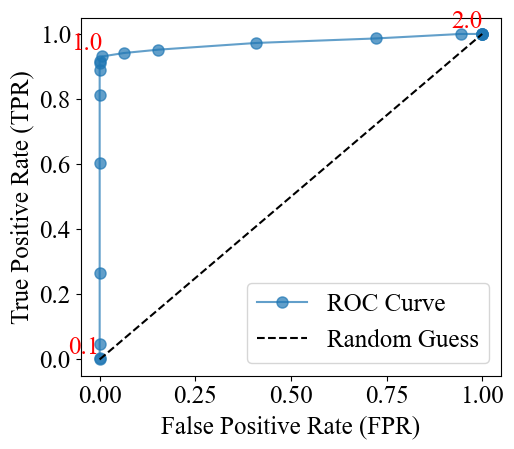

In [4]:
from plotting import plot_ROC

y_true = [test_case[2] for test_case in all_test_cases] # Create list consisting of the correct classifications

y_pred_list, test_data = run_test(y_true)

plot_ROC(y_true, y_pred_list, VERIFICATION_THRESHOLDS, 1)

### 5. Plot the confusion matrix

Confusion Matrix for test 1 with threshold 0.1:


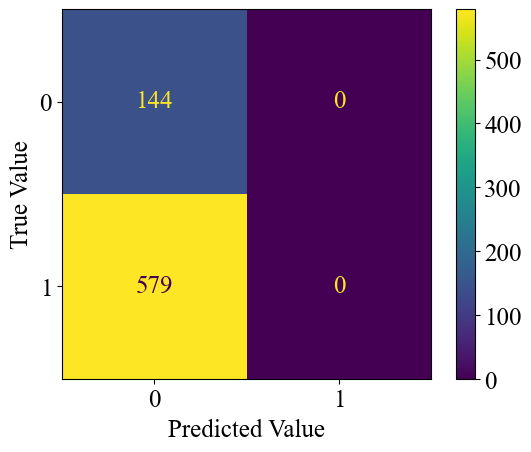

Confusion Matrix for test 1 with threshold 0.2:


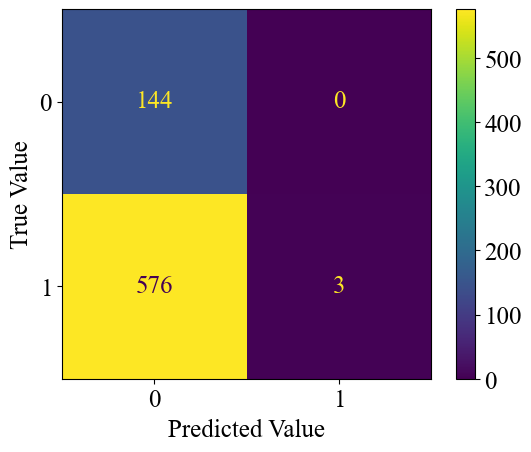

Confusion Matrix for test 1 with threshold 0.30000000000000004:


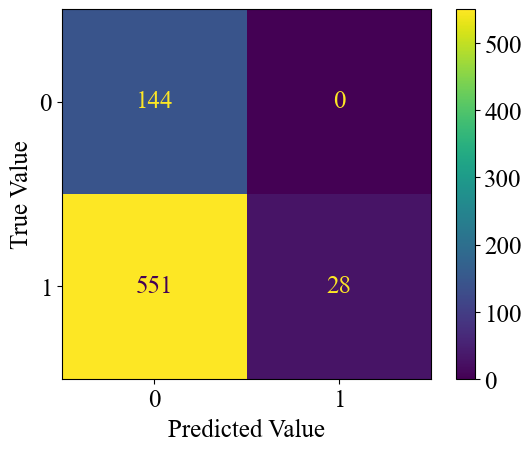

Confusion Matrix for test 1 with threshold 0.4:


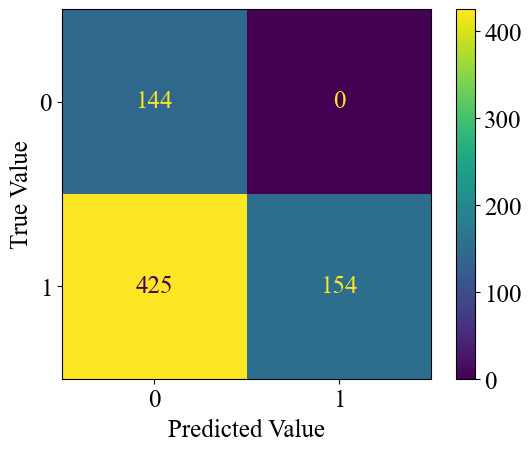

Confusion Matrix for test 1 with threshold 0.5:


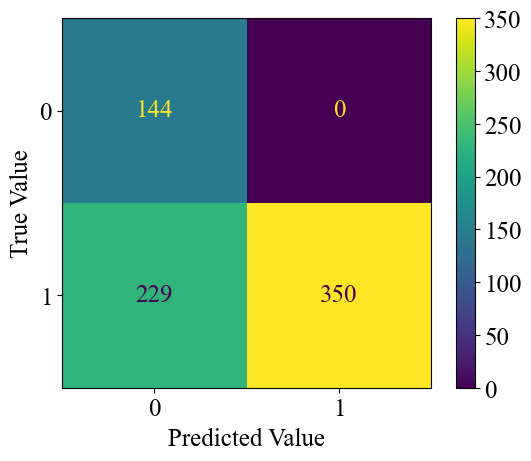

Confusion Matrix for test 1 with threshold 0.6:


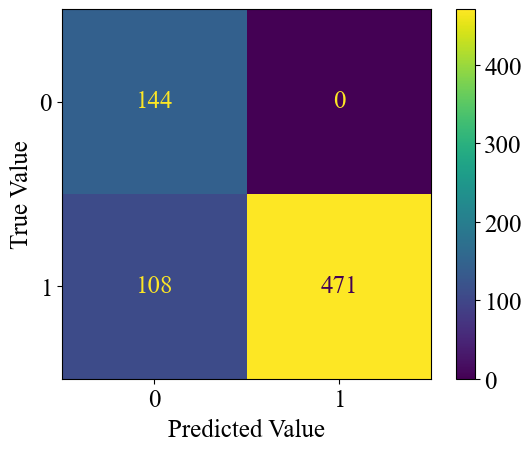

Confusion Matrix for test 1 with threshold 0.7000000000000001:


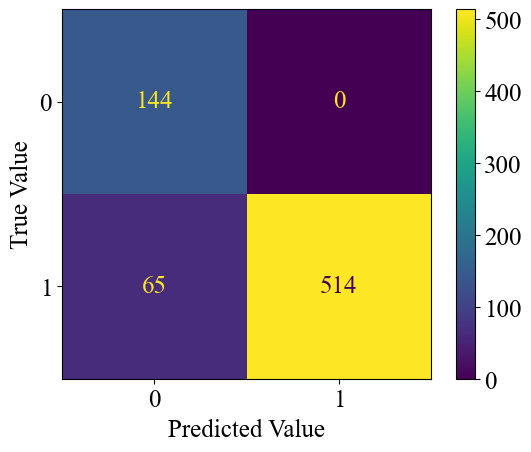

Confusion Matrix for test 1 with threshold 0.8:


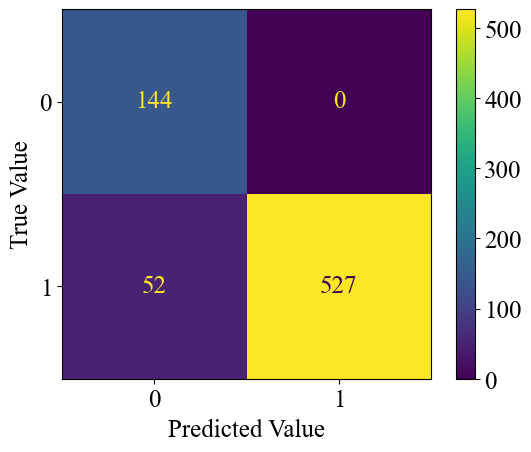

Confusion Matrix for test 1 with threshold 0.9:


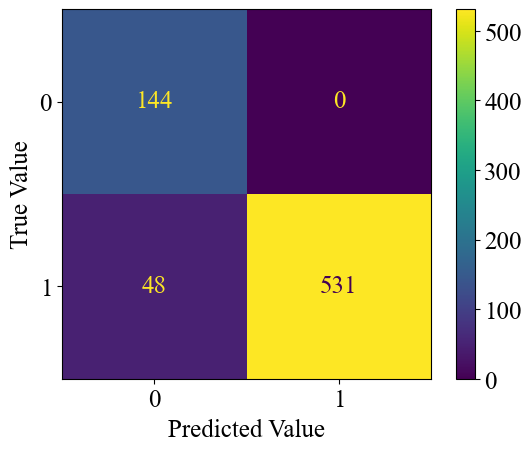

Confusion Matrix for test 1 with threshold 1.0:


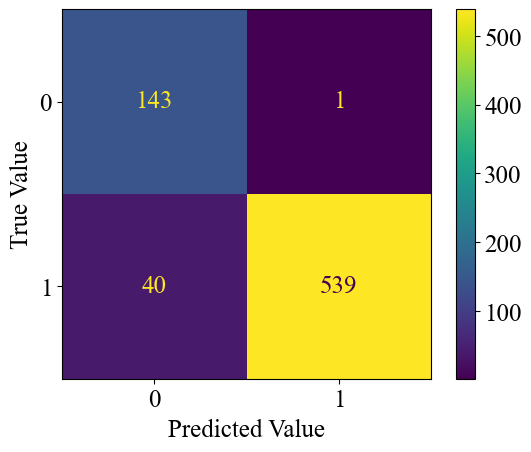

Confusion Matrix for test 1 with threshold 1.1:


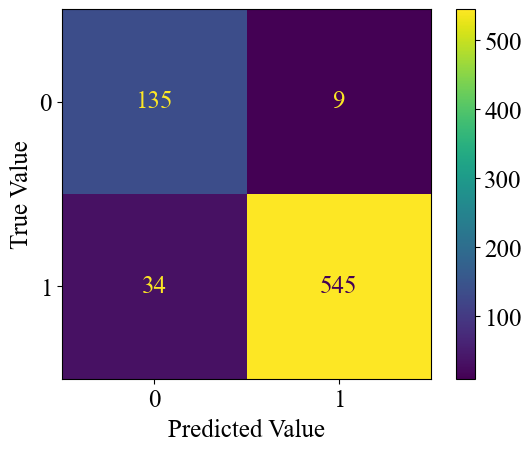

Confusion Matrix for test 1 with threshold 1.2000000000000002:


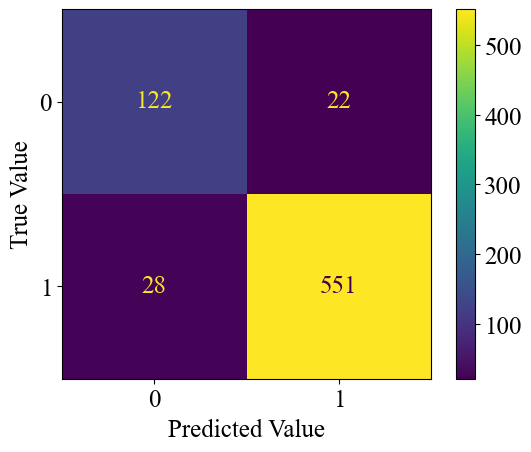

Confusion Matrix for test 1 with threshold 1.3000000000000003:


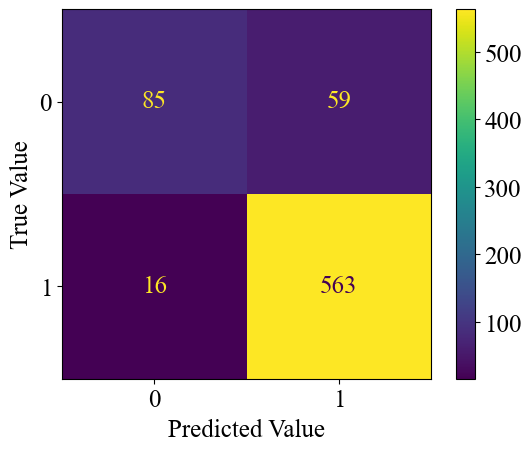

Confusion Matrix for test 1 with threshold 1.4000000000000001:


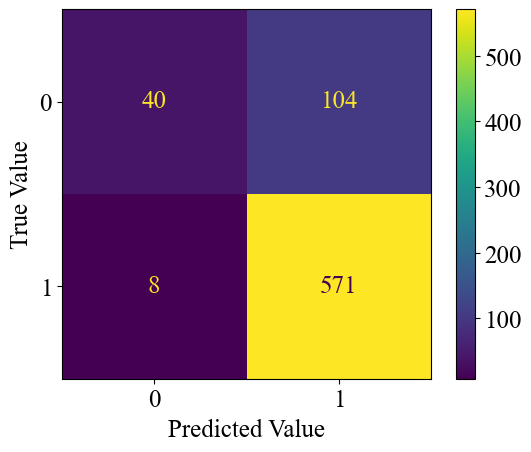

Confusion Matrix for test 1 with threshold 1.5000000000000002:


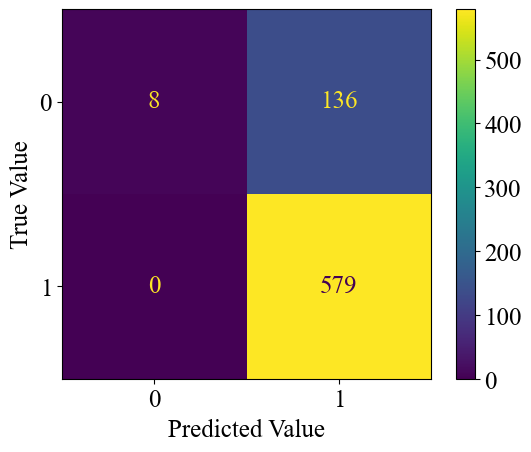

Confusion Matrix for test 1 with threshold 1.6:


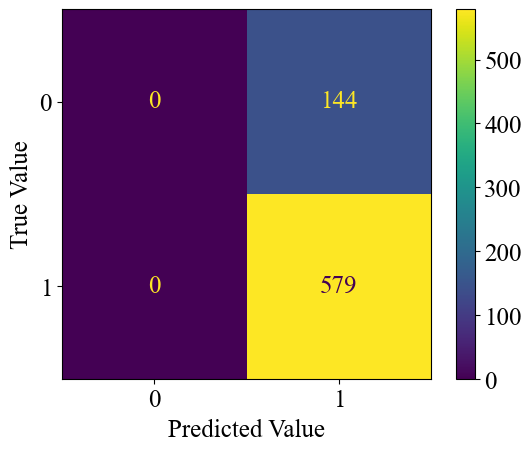

Confusion Matrix for test 1 with threshold 1.7000000000000002:


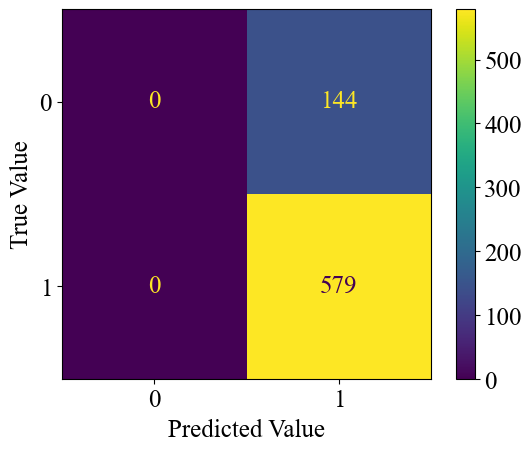

Confusion Matrix for test 1 with threshold 1.8000000000000003:


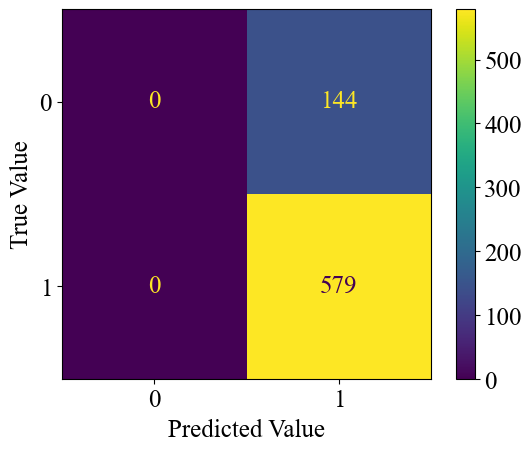

Confusion Matrix for test 1 with threshold 1.9000000000000001:


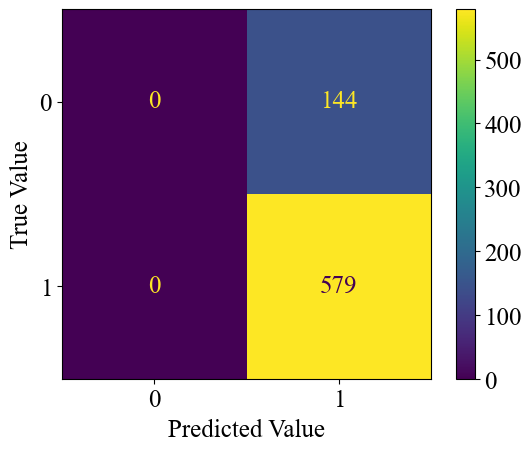

Confusion Matrix for test 1 with threshold 2.0:


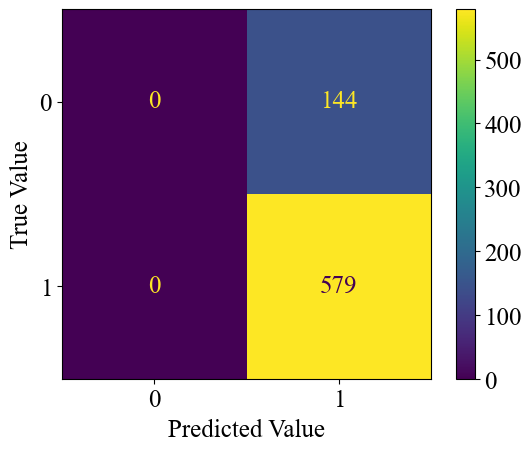

In [5]:
from plotting import plot_conf_mat

for y_pred, threshold in zip(y_pred_list, VERIFICATION_THRESHOLDS):
    plot_conf_mat(y_true, y_pred, threshold, 1)


### 6. Analyze and save the results

In [6]:
# Inspect the performance metrics of the model on the test data
test_data_formatted = test_data.copy()
test_data_formatted['Threshold'] = test_data['Threshold'].map('{:.1f}'.format)
for col in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
    test_data_formatted[col] = test_data[col].map('{:.4f}'.format)

test_data_formatted

,Threshold,Accuracy,Precision,Recall,F1-score,Undetected,Misaligned
0,0.1,0.1992,0.0000,0.0000,0.0000,39,1917
1,0.2,0.2033,1.0000,0.0052,0.0103,39,1917
2,0.3,0.2379,1.0000,0.0484,0.0923,39,1917
3,0.4,0.4122,1.0000,0.2660,0.4202,39,1917
4,0.5,0.6833,1.0000,0.6045,0.7535,39,1917
5,0.6,0.8506,1.0000,0.8135,0.8971,39,1917
6,0.7,0.9101,1.0000,0.8877,0.9405,39,1917
7,0.8,0.9281,1.0000,0.9102,0.9530,39,1917
8,0.9,0.9336,1.0000,0.9171,0.9568,39,1917
9,1.0,0.9433,0.9981,0.9309,0.9634,39,1917


In [7]:
# Save the results to CSV and Excel files
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

test_data_formatted.to_csv(f"{SAVE_PATH}test_results_PERF.csv", index=False)
test_data_formatted.to_excel(f"{SAVE_PATH}test_results_PERF.xlsx", index=False)